# Init

In [4]:
from google.colab import drive
from pathlib import Path
import sys
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
from PIL import Image
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt




In [5]:
drive.mount('/content/drive')

drive_root = Path("/content/drive/MyDrive")

Mounted at /content/drive


In [6]:

repo_path = drive_root / "Repo"
code_path = repo_path / "ProyectoCNN" / "code"
data_path = drive_root / "ProyectoCNNv2"

sys.path.append(str(code_path))

print("Repo encontrado:", repo_path.exists())
print("Code encontrado:", code_path.exists())
print("Data encontrada:", data_path.exists())

Repo encontrado: True
Code encontrado: True
Data encontrada: True


# Preparacion Entorno

In [7]:
from genCSVMap import prepare_labels_dataset

In [8]:
df = pd.read_csv(data_path / "Data_Entry_2017.csv")
print(df.head())

        Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_000.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           81              M            PA                 2500     2048   
4           81              F            PA                 2582     2991   

   OriginalImagePixelSpacing[x     y]  Unnamed: 11  
0                        0.143  0.143          NaN 

In [9]:
labels_df, train_val_df, test_df = prepare_labels_dataset(
    base_path='/content/drive/MyDrive/ProyectoCNNv2'
)


One-hot encoding diseases: 100%|██████████| 14/14 [00:00<00:00, 21.63it/s]


Buscando imágenes en subcarpetas...
112121 imágenes encontradas en estructura de carpetas.
✅ Dataset procesado guardado en: /content/drive/MyDrive/ProyectoCNNv2/IdxDataset.csv
Train/Val: 86524 imágenes
Test: 25596 imágenes

Ejemplo (primeras 5 filas):
        Image_Index                                               Path  \
0  00000001_000.png  /content/drive/MyDrive/ProyectoCNNv2/images_00...   
1  00000001_001.png  /content/drive/MyDrive/ProyectoCNNv2/images_00...   
2  00000001_002.png  /content/drive/MyDrive/ProyectoCNNv2/images_00...   
3  00000002_000.png  /content/drive/MyDrive/ProyectoCNNv2/images_00...   
4  00000003_000.png  /content/drive/MyDrive/ProyectoCNNv2/images_00...   

   Gender_Code  View_Code  Atelectasis  Consolidation  Infiltration  \
0            1          1            0              0             0   
1            1          1            0              0             0   
2            1          1            0              0             0   
3            1     

In [10]:
labels_df

,Image_Index,Path,Gender_Code,View_Code,Atelectasis,Consolidation,Infiltration,Pneumothorax,Edema,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia
0,00000001_000.png,/content/drive/MyDrive/ProyectoCNNv2/images_00...,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,00000001_001.png,/content/drive/MyDrive/ProyectoCNNv2/images_00...,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0
2,00000001_002.png,/content/drive/MyDrive/ProyectoCNNv2/images_00...,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0
3,00000002_000.png,/content/drive/MyDrive/ProyectoCNNv2/images_00...,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,00000003_000.png,/content/drive/MyDrive/ProyectoCNNv2/images_00...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,/content/drive/MyDrive/ProyectoCNNv2/images_01...,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
112116,00030802_000.png,/content/drive/MyDrive/ProyectoCNNv2/images_01...,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
112117,00030803_000.png,/content/drive/MyDrive/ProyectoCNNv2/images_01...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
112118,00030804_000.png,/content/drive/MyDrive/ProyectoCNNv2/images_01...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
train_val_df

,Image_Index,Path,Gender_Code,View_Code,Atelectasis,Consolidation,Infiltration,Pneumothorax,Edema,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia
0,00000001_000.png,/content/drive/MyDrive/ProyectoCNNv2/images_00...,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,00000001_001.png,/content/drive/MyDrive/ProyectoCNNv2/images_00...,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0
2,00000001_002.png,/content/drive/MyDrive/ProyectoCNNv2/images_00...,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0
3,00000002_000.png,/content/drive/MyDrive/ProyectoCNNv2/images_00...,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,00000004_000.png,/content/drive/MyDrive/ProyectoCNNv2/images_00...,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86519,00030789_000.png,/content/drive/MyDrive/ProyectoCNNv2/images_01...,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
86520,00030793_000.png,/content/drive/MyDrive/ProyectoCNNv2/images_01...,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0
86521,00030795_000.png,/content/drive/MyDrive/ProyectoCNNv2/images_01...,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
86522,00030801_000.png,/content/drive/MyDrive/ProyectoCNNv2/images_01...,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
test_df

,Image_Index,Path,Gender_Code,View_Code,Atelectasis,Consolidation,Infiltration,Pneumothorax,Edema,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia
0,00000003_000.png,/content/drive/MyDrive/ProyectoCNNv2/images_00...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,00000003_001.png,/content/drive/MyDrive/ProyectoCNNv2/images_00...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,00000003_002.png,/content/drive/MyDrive/ProyectoCNNv2/images_00...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,00000003_003.png,/content/drive/MyDrive/ProyectoCNNv2/images_00...,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1
4,00000003_004.png,/content/drive/MyDrive/ProyectoCNNv2/images_00...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25591,00030800_000.png,/content/drive/MyDrive/ProyectoCNNv2/images_01...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25592,00030802_000.png,/content/drive/MyDrive/ProyectoCNNv2/images_01...,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25593,00030803_000.png,/content/drive/MyDrive/ProyectoCNNv2/images_01...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25594,00030804_000.png,/content/drive/MyDrive/ProyectoCNNv2/images_01...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
labels_df.columns

Index(['Image_Index', 'Path', 'Gender_Code', 'View_Code', 'Atelectasis',
       'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema',
       'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
       'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'],
      dtype='object')

In [14]:
train_df, val_df = train_test_split( train_val_df, test_size=0.2, random_state=42)

print(f"Train: {len(train_df)} imágenes")
print(f"Val:   {len(val_df)} imágenes")
print(f"Test:  {len(test_df)} imágenes")

Train: 69219 imágenes
Val:   17305 imágenes
Test:  25596 imágenes


# Transforming

In [15]:
DISEASE_COLUMNS = [
    'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax',
    'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia',
    'Pleural_Thickening', 'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'
]

In [16]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomAdjustSharpness(2, p=0.5),
    transforms.RandomAutocontrast(p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [17]:
from datasetMgr import datasetMgr

In [18]:
train_dataset = datasetMgr(dataframe=train_df,disease_columns=DISEASE_COLUMNS,transform=train_transform)
val_dataset = datasetMgr(dataframe=val_df,disease_columns=DISEASE_COLUMNS,transform=val_transform)
test_dataset = datasetMgr(dataframe=test_df,disease_columns=DISEASE_COLUMNS,transform=val_transform)

In [19]:
print(f"Train dataset: {len(train_dataset)} muestras")
print(f"Val dataset:   {len(val_dataset)} muestras")
print(f"Test dataset:  {len(test_dataset)} muestras")


Train dataset: 69219 muestras
Val dataset:   17305 muestras
Test dataset:  25596 muestras


## Dataloader

In [20]:
BATCH_SIZE = 32

In [21]:
NUM_WORKERS = 2 # Para Colab pongan 2 o 4, no se pasen

In [22]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True, drop_last=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True, drop_last=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True, drop_last=False)

### Dataloaders Creados

In [23]:
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches:   {len(val_loader)}")
print(f"   Test batches:  {len(test_loader)}")

   Train batches: 2164
   Val batches:   541
   Test batches:  800


In [24]:
images, labels = next(iter(train_loader))

print(f"\nBatch de entrenamiento:")
print(f"Imágenes shape: {images.shape}")      # Debe ser (32, 3, 224, 224) para ser compatible por RESNET
print(f"Labels shape:   {labels.shape}")      # Debe ser (32, 14) IDEM
print(f"Imágenes - Min: {images.min():.3f}, Max: {images.max():.3f}")
print(f"Labels - Min:   {labels.min():.0f}, Max: {labels.max():.0f}")


print(f"\n  Labels por enfermedad en este batch:")
for i, disease in enumerate(DISEASE_COLUMNS):
    count = labels[:, i].sum().item()
    print(f"    {disease:20s}: {count:.0f}/{BATCH_SIZE}")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Batch de entrenamiento:
Imágenes shape: torch.Size([32, 3, 224, 224])
Labels shape:   torch.Size([32, 14])
Imágenes - Min: -2.118, Max: 2.640
Labels - Min:   0, Max: 1

  Labels por enfermedad en este batch:
    Atelectasis         : 3/32
    Consolidation       : 1/32
    Infiltration        : 7/32
    Pneumothorax        : 1/32
    Edema               : 0/32
    Emphysema           : 0/32
    Fibrosis            : 1/32
    Effusion            : 5/32
    Pneumonia           : 0/32
    Pleural_Thickening  : 1/32
    Cardiomegaly        : 0/32
    Nodule              : 0/32
    Mass                : 1/32
    Hernia              : 0/32


### Imagenes de ejemplo con Data Augmentation


Visualizando imágenes de ejemplo...


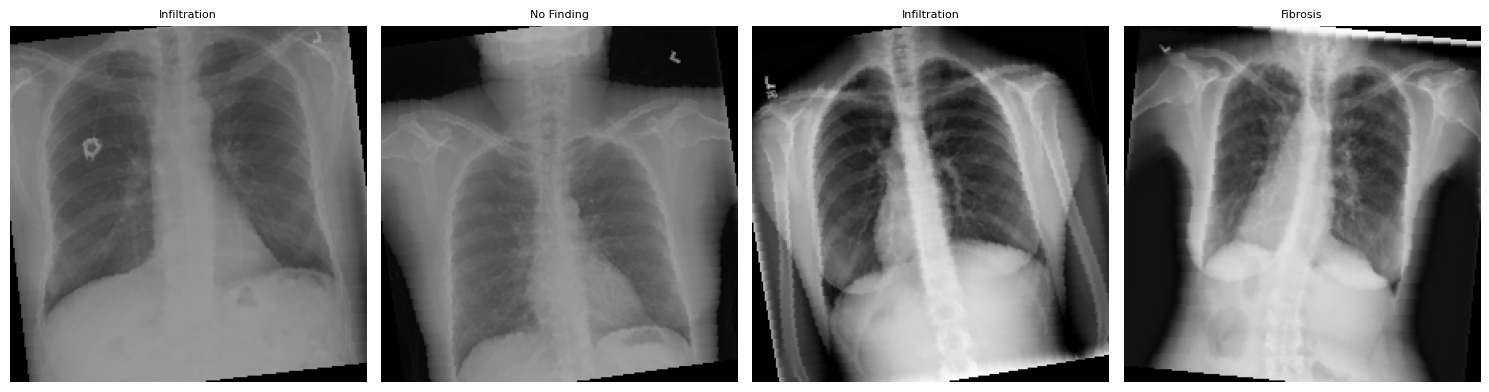

In [25]:

def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor * std + mean

def show_batch(images, labels, n=4):
    fig, axes = plt.subplots(1, n, figsize=(15, 4))

    for i in range(n):
        img = denormalize(images[i].cpu())
        img = img.permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)

        diseases = [DISEASE_COLUMNS[j] for j in range(14) if labels[i, j] == 1]
        diseases_str = '\n'.join(diseases[:3]) if diseases else 'No Finding'

        axes[i].imshow(img)
        axes[i].set_title(diseases_str, fontsize=8)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

print("\nVisualizando imágenes de ejemplo...")
show_batch(images, labels, n=4)

In [26]:
len(DISEASE_COLUMNS)

14

## Transfer Learning

In [31]:
import torch.nn as nn
from torchvision import models
from tqdm import tqdm

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [29]:
num_classes = len(DISEASE_COLUMNS)

### DenseNet121

In [ ]:
modelDenseNet121 = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)

for param in modelDenseNet121.features.parameters():
    param.requires_grad = False


In [ ]:
# Reemplazamos la capa final
in_features = modelDenseNet121.classifier.in_features
modelDenseNet121.classifier = nn.Sequential(
    nn.Linear(in_features, num_classes),
    nn.Sigmoid()  # salida multi-label
)
modelDenseNet121 = modelDenseNet121.to(device)

#### Optimizador

In [ ]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(modelDenseNet121.classifier.parameters(), lr=1e-4)

#### Entrenamiento

In [ ]:
num_epochs = 5
train_losses = []

for epoch in range(num_epochs):
    modelDenseNet121.train()
    running_loss = 0.0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device).float()

        optimizer.zero_grad()
        outputs = modelDenseNet121(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}")


#### Evaluacion DenseNet121

In [ ]:
modelDenseNet121.eval()
all_labels = []
all_outputs = []

with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Evaluando"):
        images = images.to(device)
        outputs = modelDenseNet121(images)
        all_outputs.append(outputs.cpu().numpy())
        all_labels.append(labels.numpy())

all_outputs = np.concatenate(all_outputs)
all_labels = np.concatenate(all_labels)

#### Evaluación AUC

In [ ]:
try:
    auc_scores = []
    for i in range(num_classes):
        if np.sum(all_labels[:, i]) > 0:
            auc = roc_auc_score(all_labels[:, i], all_outputs[:, i])
            auc_scores.append(auc)
        else:
            auc_scores.append(np.nan)
    mean_auc = np.nanmean(auc_scores)
    print(f"\nAUC promedio: {mean_auc:.4f}")
    print("AUC por clase:", np.round(auc_scores, 3))
except Exception as e:
    print("Error al calcular AUC:", e)